# Object detection using YOLOv2 for Coursera's Convolution Neural Networks course

This file has two parts
1. Implementation of two filters for discarding bounding boxes (score threshold and non-max suppression)
2. Applying pre-trained weights from YOLO website and testing out the YOLOv2 algorithm for object detection

Also, made a couple minor modifications to the plotting routines that are provided in the course
- Fixed a bug in the original yolo_utils.py file for drawing bounding boxes (it was not scaling bounding box coordinates to the image dimensions)
- Made output image larger

In [1]:
# import packages
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import imageio
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

%load_ext autoreload
%autoreload 2

/Users/ccl/anaconda3/envs/test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Set up filters (score threshold and non-max-suppression)

In [2]:
# discard boxes where probability of object is lower than a score threshold

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores,axis=-1)
    box_class_scores = K.max(box_scores,axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = box_class_scores >= threshold
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, mask = filtering_mask)
    boxes = tf.boolean_mask(boxes, mask = filtering_mask)
    classes = tf.boolean_mask(box_classes, mask = filtering_mask)
    
    return scores, boxes, classes

In [3]:
# computes iou between two boxes

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Intersection of box1 and box2 is a box; calculate the coordinates of the corners and the area
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = max(yi2 - yi1,0) * max(xi2 - xi1,0)

    # Calculate union using formula Union(A,B) = A + B - Intersection(A,B)
    box1_area = np.abs(box1[2] - box1[0]) * np.abs(box1[3] - box1[1])
    box2_area = np.abs(box2[2] - box2[0]) * np.abs(box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    # intersection over area
    iou = float(inter_area) / float(union_area)
    
    return iou

In [4]:
# performs non max supression, which works as follows:
# 1. pick box with highest score
# 2. remove any boxes that overlap with iou > iou_threshold
# 3. pick next box with highest score
# 4. continue until number of detected boxes = max_boxes

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32') # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold = iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [5]:
# takes YOLO output and performs score threshold and non-max threshold

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold= score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    
    return scores, boxes, classes

# 2. Set up YOLOv2 model

In [6]:
sess = K.get_session() # start session

## Read in classes, anchor boxes, and image shape

In [7]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

## Load pre-trained weights

In [8]:
yolo_model = load_model("model_data/yolo.h5")

/Users/ccl/anaconda3/envs/test/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [10]:
# convert to format used for filter

yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [11]:
# filter

scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [12]:
# run YOLO on image

def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    img_path = "images/" + image_file
    image, image_data = preprocess_image(img_path, model_image_size = (608, 608))
    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict={yolo_model.input:image_data,K.learning_phase():0})

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    
    fig = plt.figure(figsize=(10,10)) # create an empty figure to plot into (makes image larger)
    imshow(image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for dogs.jpg
dog 0.63 (24, 176) (74, 234)
dog 0.65 (328, 4) (398, 243)
giraffe 0.71 (395, 17) (474, 230)
dog 0.80 (76, 156) (125, 235)
dog 0.83 (167, 88) (251, 236)
dog 0.85 (120, 138) (178, 234)
dog 0.88 (248, 66) (337, 235)


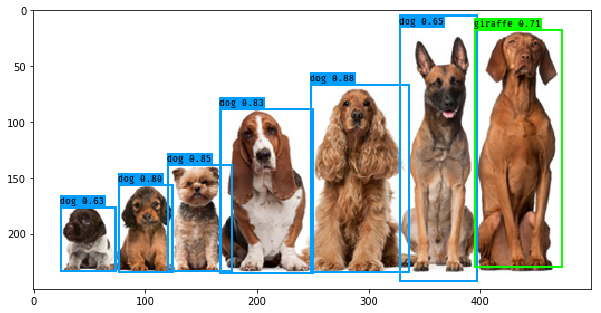

In [13]:
#image = '0007.jpg'
#image = 'giraffe.jpg'
image = 'dogs.jpg'
#image = 'dog.jpg'
#image = 'test.jpg'

# test image
out_scores, out_boxes, out_classes = predict(sess, image)

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 